In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

from preprocessing import split_data
import acquire
from prepare import prepare_data, count_outliers, \
                    missing_value_percentage

import warnings
warnings.filterwarnings('ignore')

#### First we acquire the zillow data and turn it into a useable .csv file

In [2]:
df = acquire.zillow_data()
df = acquire.acquire_data()

In [3]:
# Check how many outliers are in unprocessed data
for s in df.select_dtypes('number'):
    print(count_outliers(df[s],'iqr'))
# We decided to drop any data that was outside of 3 times the IQR
# of each column

20
0
1743
8
1
26
7
0
0
26
0
22
134
134
0
0
31
3
0
1212
23
3213
54
0
0
0
0
2149
0
1
0
0
0
0
0
801
0
0
12
0
0
79
1
30
12
0
0
0
0
821
725
0
583
780
19
1
0
1458


In [4]:
# Check percentage of missing values in unprocessed data
for s in df.select_dtypes('number'):
    print(missing_value_percentage(df[s]))
# We decided to drop columns that are missing more than 30% 
# of their data

0.0
0.0
0.7399412684489531
0.998665192021662
0.9991037717859731
0.0
0.0
1.0
0.356603485755692
0.0026124099004614623
0.9925822813775218
0.9164600892414477
0.0015636322031959116
0.004709965294992563
1.0
1.0
0.9164600892414477
0.9968536669082033
0.0
0.8618855116128294
0.0026124099004614623
0.6564776324320202
0.6564776324320202
0.9711109416116853
0.3528850921017505
0.0
0.0
0.0070363449143816025
0.7884138667480264
0.983467449754014
0.9915335036802563
0.979577437931429
0.8091415277830747
0.0
0.0
0.019774226764806835
0.0
0.637065710689905
0.0004957858205255329
0.0
0.9991037717859731
0.8717821593379352
0.998550779909233
0.3545631364173754
0.9630639563708477
0.9987986728194959
0.0022119675069600703
0.7223408718202967
0.9984554364822089
0.001601769574005568
1.906868540482819e-05
0.0
1.906868540482819e-05
7.627474161931276e-05
0.9603562030433622
0.0023454483047938676
0.0
0.0


#### Next we run our main prepare function
This function performs many tasks including dropping columns with too many null values or deemed to not be useful in modeling, creating new features, and removing outliers, among others

In [5]:
df = prepare_data()
df.head(3)

,bathroomcnt,bedroomcnt,house_size,latitude,longitude,lotsize,regionidcity,regionidzip,actual_value,logerror,age,tax_rate,estimated,LA,Orange,Ventura
52440,2.0,3.0,1762.0,33937685.0,-117996709.0,6347.0,14634,96171,522000.0,0.007204,62.0,1.210182,530730.983162,1,0,0
52439,1.0,3.0,1032.0,34040895.0,-118038169.0,5074.0,36502,96480,49546.0,0.037129,63.0,1.768922,53968.131868,1,0,0
52438,2.0,4.0,1612.0,34300140.0,-118706327.0,12105.0,27110,97116,67205.0,0.013209,53.0,1.647913,69280.370004,0,0,1


In [6]:
# Recheck number of outliers in nonencoded data
for s in df.select_dtypes('number').iloc[:,:-1]:
    print(count_outliers(df[s],'iqr'))

0
0
0
0
0
0
0
0
0
0
0
0
0


In [7]:
df.dtypes

bathroomcnt     float64
bedroomcnt      float64
house_size      float64
latitude        float64
longitude       float64
lotsize         float64
regionidcity     object
regionidzip      object
actual_value    float64
logerror        float64
age             float64
tax_rate        float64
estimated       float64
LA                uint8
Orange            uint8
Ventura           uint8
dtype: object

In [8]:
df.shape

(41741, 16)

### Some exploration to look at the data

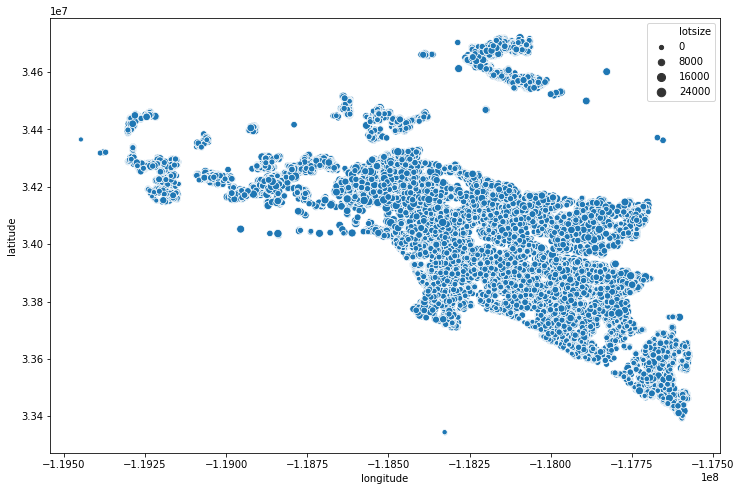

In [9]:
plt.rc('figure',figsize=(12,8))
sns.scatterplot('longitude', 'latitude', data=df, size='lotsize')

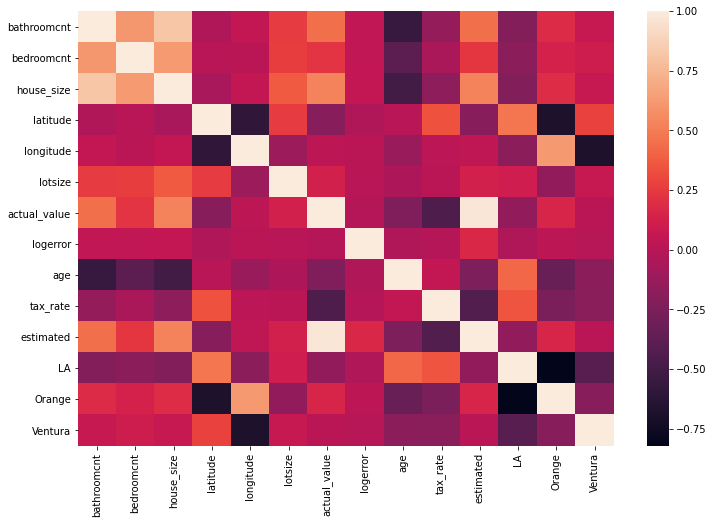

In [10]:
sns.heatmap(df.corr())

## Split our data

In [11]:
train, validate, test = split_data(df)
train.head(3)

,bathroomcnt,bedroomcnt,house_size,latitude,longitude,lotsize,regionidcity,regionidzip,actual_value,logerror,age,tax_rate,estimated,LA,Orange,Ventura
39903,2.0,4.0,1498.0,33991186.0,-117827282.0,8032.0,24384,96505,312264.0,-0.023107,46.0,1.218741,296084.211495,1,0,0
25501,2.5,3.0,1729.0,33584421.0,-117644775.0,5400.0,12773,96996,479202.0,0.017473,25.0,1.007404,498874.336287,0,1,0
22151,3.0,4.0,2824.0,34261050.0,-118567605.0,17507.0,12447,96346,552275.0,0.028148,49.0,1.253571,589255.063927,1,0,0


Text(0.5, 0, 'logerror')

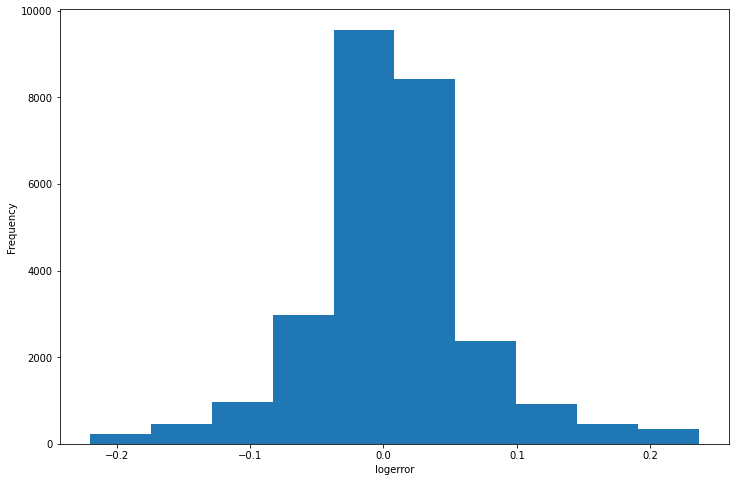

In [12]:
train.logerror.plot.hist()
plt.xlabel('logerror')

Text(0.5, 0, 'scaled estimated value')

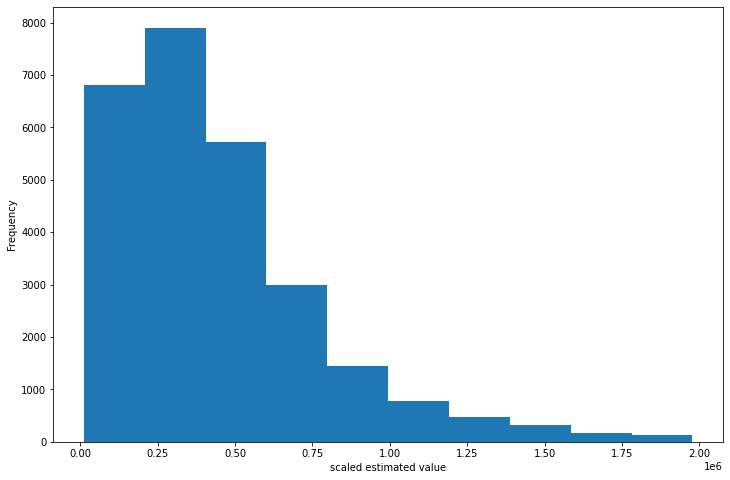

In [13]:
train.estimated.plot.hist()
plt.xlabel('scaled estimated value')

## Elbow method to determine best k value for each prospective model

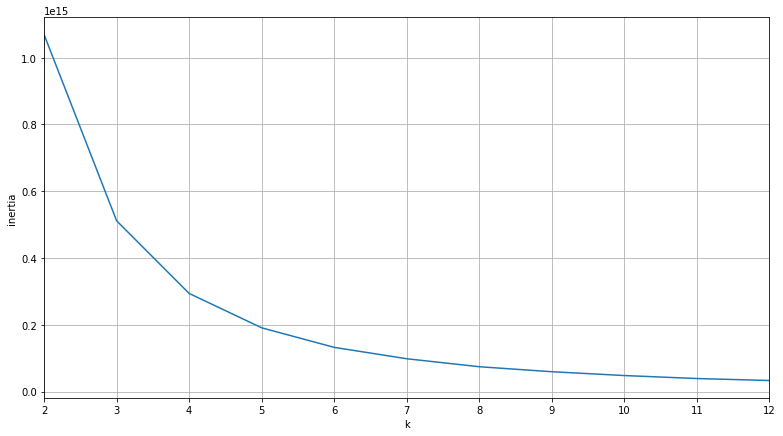

In [14]:
# Model based on estimated value
X = train[['estimated']]
def get_inertia(k):
    kmeans = KMeans(k, random_state=42)
    kmeans.fit(X)
    return kmeans.inertia_

plt.figure(figsize=(13, 7))
pd.Series({k: get_inertia(k) for k in range(2, 13)}).plot()
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(range(2, 13))
plt.grid()

From above k = 6 looks like a good elbow point

Text(0.5, 1.0, 'Estimated value by cluster')

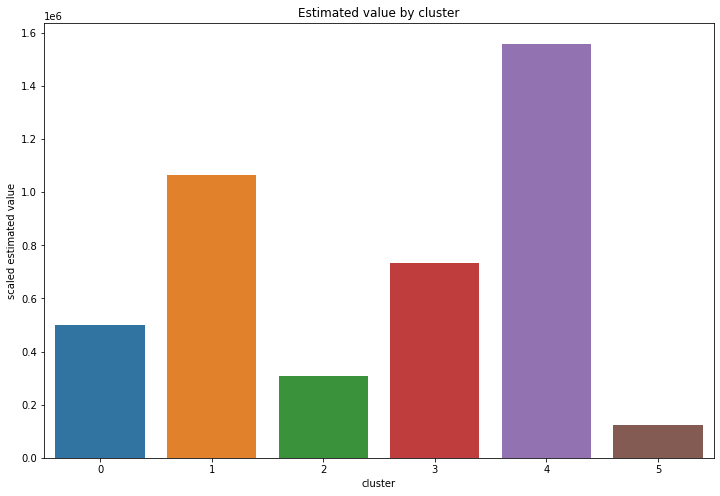

In [15]:
k = 6
X = train[['estimated']]
kmeans = KMeans(k, random_state=42)
kmeans.fit(X)
center = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
sns.barplot(x = center.index, y = center.estimated)
plt.xlabel('cluster')
plt.ylabel('scaled estimated value')
plt.title('Estimated value by cluster')

In [16]:
train['cluster'] = kmeans.predict(train[['estimated']])
train.cluster = 'cluster ' + train.cluster.astype(str)
cluster_df = pd.get_dummies(train.cluster)
# concatenate the dataframe with the 6 cluster columns 
# to the original dataframe
train= pd.concat([train, cluster_df], axis =1)
train.head(3)

,bathroomcnt,bedroomcnt,house_size,latitude,longitude,lotsize,regionidcity,regionidzip,actual_value,logerror,...,LA,Orange,Ventura,cluster,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5
39903,2.0,4.0,1498.0,33991186.0,-117827282.0,8032.0,24384,96505,312264.0,-0.023107,...,1,0,0,cluster 2,0,0,1,0,0,0
25501,2.5,3.0,1729.0,33584421.0,-117644775.0,5400.0,12773,96996,479202.0,0.017473,...,0,1,0,cluster 0,1,0,0,0,0,0
22151,3.0,4.0,2824.0,34261050.0,-118567605.0,17507.0,12447,96346,552275.0,0.028148,...,1,0,0,cluster 0,1,0,0,0,0,0


In [17]:
train.cluster.value_counts()

cluster 2    7573
cluster 5    7082
cluster 0    6056
cluster 3    3550
cluster 1    1679
cluster 4     773
Name: cluster, dtype: int64

#### This combined with the chart above shows that the lower value homes (those in clusters 0, 2 and 5) are by far the most sold 

Text(0.5, 1.0, 'Visualizing Cluster Centers')

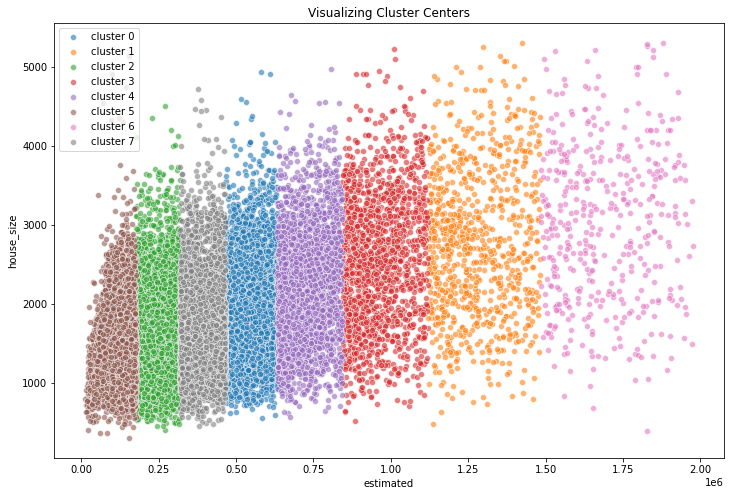

In [18]:
X = train[['estimated']]
kmeans = KMeans(6, random_state=42)
kmeans.fit(X)
train['cluster'] = kmeans.predict(X)
for cluster, subset in train.groupby('cluster'):
    sns.scatterplot(subset.estimated, 
                    subset.house_size, 
                label='cluster ' + str(cluster), alpha=.6)

# center = pd.DataFrame(kmeans.cluster_centers_,  columns=X.columns)
# plt.scatter(x = center.house_size, 
#             y = center.estimated, 
#             alpha=.15, s=5000, c='black')

plt.legend()
plt.xlabel('estimated')
plt.ylabel('house_size')
plt.title('Visualizing Cluster Centers')

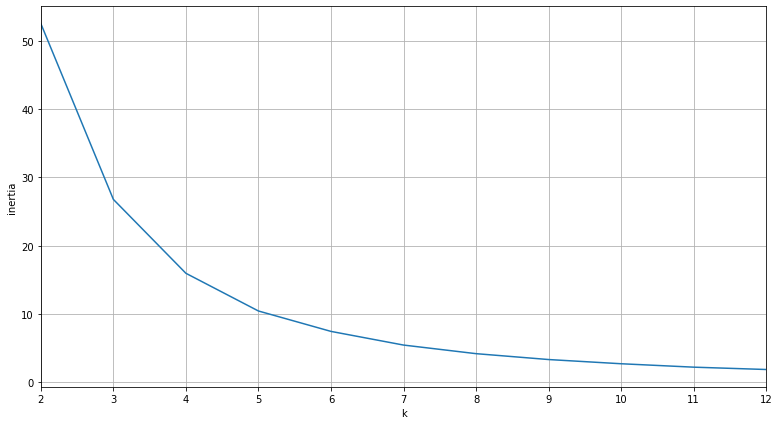

In [19]:
# Model based on logerror value
X = train[['logerror']]
def get_inertia(k):
    kmeans = KMeans(k, random_state=42)
    kmeans.fit(X)
    return kmeans.inertia_

plt.figure(figsize=(13, 7))
pd.Series({k: get_inertia(k) for k in range(2, 13)}).plot()
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(range(2, 13))
plt.grid()

Text(0.5, 1.0, 'Visualizing Cluster Centers')

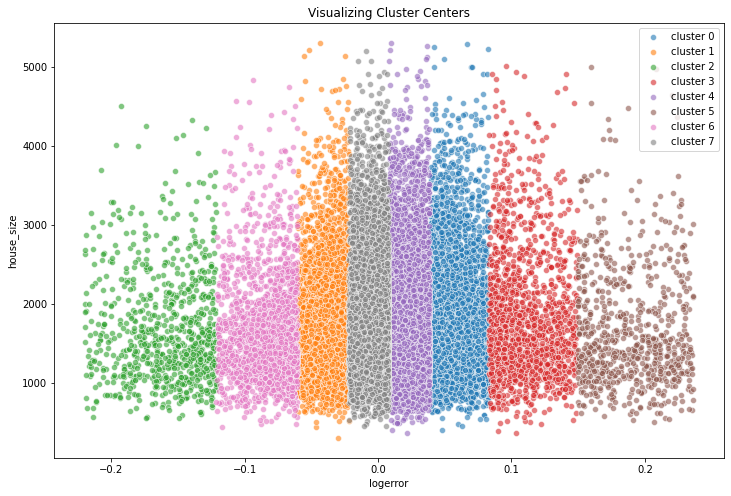

In [20]:
X = train[['logerror']]
kmeans = KMeans(6, random_state=42)
kmeans.fit(X)
train['cluster'] = kmeans.predict(X)
for cluster, subset in train.groupby('cluster'):
    sns.scatterplot(subset.logerror, 
                    subset.house_size, 
                label='cluster ' + str(cluster), alpha=.6)

# center = pd.DataFrame(kmeans.cluster_centers_,  columns=X.columns)
# plt.scatter(x = center.house_size, 
#             y = center.estimated, 
#             alpha=.15, s=5000, c='black')

plt.legend()
plt.xlabel('logerror')
plt.ylabel('house_size')
plt.title('Visualizing Cluster Centers')

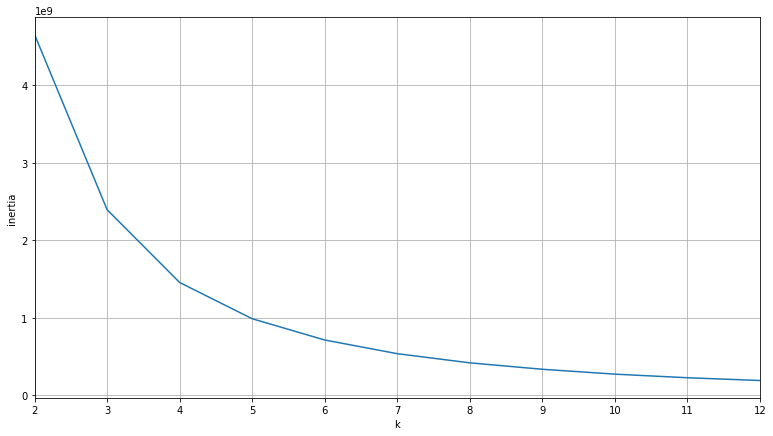

In [21]:
# Model based on house size value
X = train[['house_size']]
def get_inertia(k):
    kmeans = KMeans(k, random_state=42)
    kmeans.fit(X)
    return kmeans.inertia_

plt.figure(figsize=(13, 7))
pd.Series({k: get_inertia(k) for k in range(2, 13)}).plot()
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(range(2, 13))
plt.grid()

Text(0.5, 1.0, 'Visualizing Cluster Centers')

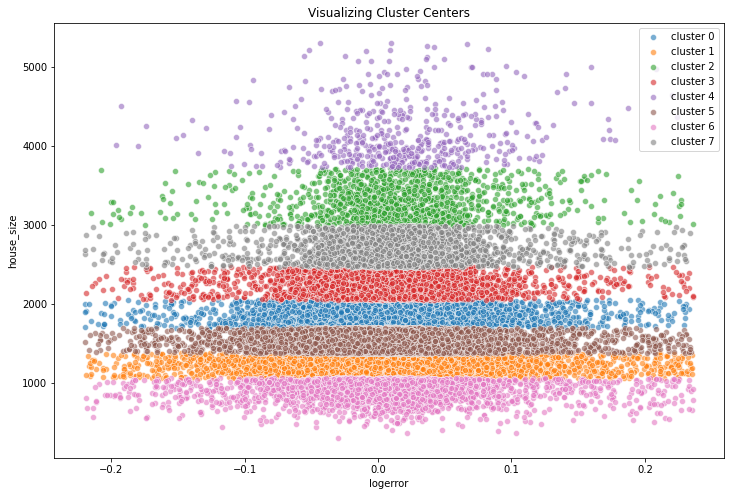

In [22]:
X = train[['house_size']]
kmeans = KMeans(6, random_state=42)
kmeans.fit(X)
train['cluster'] = kmeans.predict(X)
for cluster, subset in train.groupby('cluster'):
    sns.scatterplot(subset.logerror, 
                    subset.house_size, 
                label='cluster ' + str(cluster), alpha=.6)

# center = pd.DataFrame(kmeans.cluster_centers_,  columns=X.columns)
# plt.scatter(x = center.house_size, 
#             y = center.estimated, 
#             alpha=.15, s=5000, c='black')

plt.legend()
plt.xlabel('logerror')
plt.ylabel('house_size')
plt.title('Visualizing Cluster Centers')

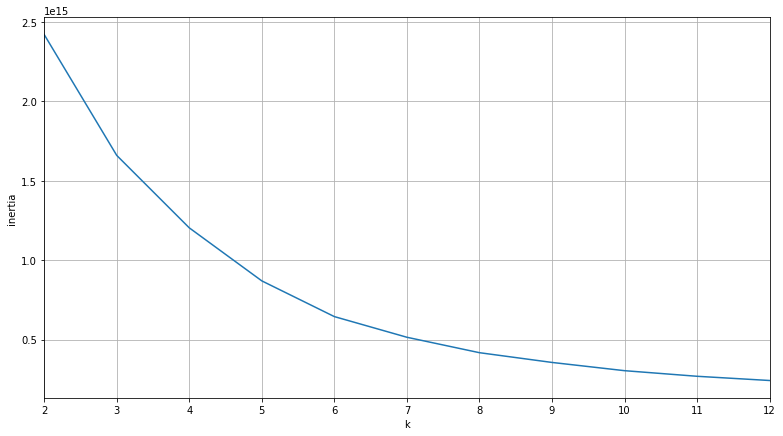

In [23]:
# Model based on location value
X = train[['latitude','longitude']]
def get_inertia(k):
    kmeans = KMeans(k, random_state=42)
    kmeans.fit(X)
    return kmeans.inertia_

plt.figure(figsize=(13, 7))
pd.Series({k: get_inertia(k) for k in range(2, 13)}).plot()
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(range(2, 13))
plt.grid()

From above k = 8 looks like a good elbow point

Text(0.5, 1.0, 'Visualizing Cluster Centers')

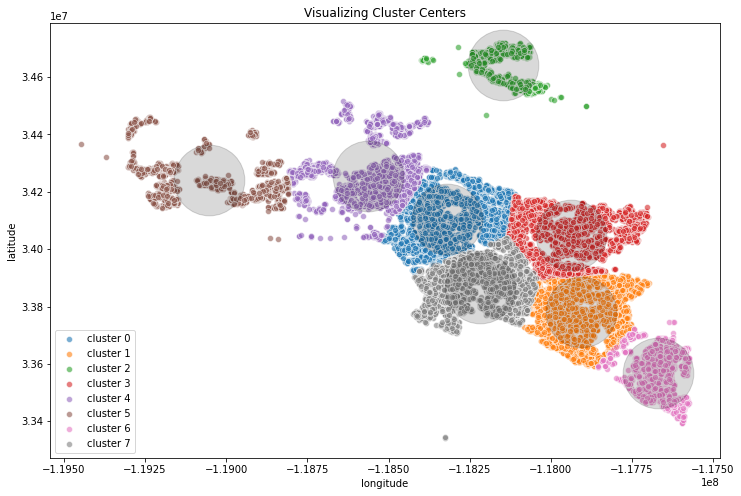

In [24]:
X = train[['latitude','longitude']]
kmeans = KMeans(8, random_state=42)
kmeans.fit(X)
train['cluster'] = kmeans.predict(X)
for cluster, subset in train.groupby('cluster'):
    sns.scatterplot(subset.longitude, subset.latitude, 
                label='cluster ' + str(cluster), alpha=.6)

center = pd.DataFrame(kmeans.cluster_centers_,  columns=X.columns)
plt.scatter(x = center.longitude, y = center.latitude, 
            alpha=.15, s=5000, c='black')

plt.legend()
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Visualizing Cluster Centers')

# Modeling

In [27]:
MSE = mean_squared_error(train.actual_value, train.estimated)
RMSE_estimate = np.sqrt(MSE)
RMSE_estimate

77695.66288586396

In [28]:
train['baseline']=train.actual_value.mean()

MSE_baseline = mean_squared_error(train.actual_value, train.baseline)
RMSE_baseline = np.sqrt(MSE_baseline)
RMSE_baseline

315660.71230442636

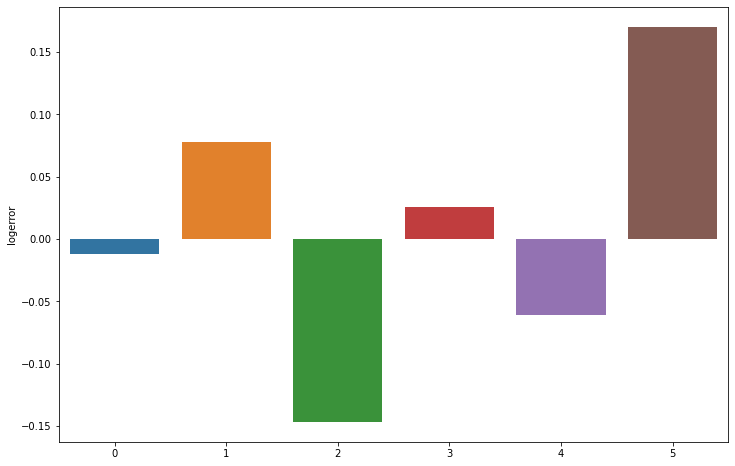

In [31]:
k = 6
X = train[['logerror']]
kmeans = KMeans(k, random_state=42)
kmeans.fit(X)
center = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
sns.barplot(x = center.index, y = center.logerror)

In [33]:
train['cluster'] = kmeans.predict(train[['logerror']])
cluster_df = pd.get_dummies(train.cluster)
cluster_df.columns = ['cluster_a', 'cluster_b', 'cluster_c',
                      'cluster_d', 'cluster_e','cluster_f']
# concatenate the dataframe with the 3 county columns 
# to the original dataframe
train= pd.concat([train, cluster_df], axis =1)
# drop regionidcounty and fips columns
train = train.drop(columns = ['cluster'])
train.head()

,bathroomcnt,bedroomcnt,house_size,latitude,longitude,lotsize,regionidcity,regionidzip,actual_value,logerror,...,cluster 3,cluster 4,cluster 5,baseline,cluster_a,cluster_b,cluster_c,cluster_d,cluster_e,cluster_f
39903,2.0,4.0,1498.0,33991186.0,-117827282.0,8032.0,24384,96505,312264.0,-0.023107,...,0,0,0,431764.725078,1,0,0,0,0,0
25501,2.5,3.0,1729.0,33584421.0,-117644775.0,5400.0,12773,96996,479202.0,0.017473,...,0,0,0,431764.725078,0,0,0,1,0,0
22151,3.0,4.0,2824.0,34261050.0,-118567605.0,17507.0,12447,96346,552275.0,0.028148,...,0,0,0,431764.725078,0,0,0,1,0,0
21858,2.0,4.0,1464.0,34268048.0,-118679847.0,5400.0,27110,97116,190998.0,0.030073,...,0,0,1,431764.725078,0,0,0,1,0,0
8498,2.0,3.0,1648.0,33719549.0,-117816405.0,6000.0,27491,97016,273462.0,-0.003746,...,0,0,0,431764.725078,1,0,0,0,0,0


### Model prediction estimation

In [34]:
X =['bathroomcnt', 'bedroomcnt', 'house_size', 'latitude', 
    'longitude','lotsize', 'age', 'tax_rate','LA', 'Orange', 
    'Ventura', 'cluster_a', 'cluster_b', 'cluster_c','cluster_d']
Y =['actual_value']

In [40]:
lm = LinearRegression()

rfe = RFE(lm, 9)

# Transforming data using RFE
X_rfe = rfe.fit_transform(train[X],train[Y])  
mask = rfe.support_

# select the column names of the features that were 
# selected and convert them to a list for future use. 
rfe_features = train[X].columns[mask].tolist()
rfe_features

['bathroomcnt',
 'bedroomcnt',
 'tax_rate',
 'LA',
 'Orange',
 'Ventura',
 'cluster_a',
 'cluster_b',
 'cluster_c']

In [37]:
lm = LinearRegression()
lm.fit(X_rfe,train[Y])
train['prediction'] = lm.predict(X_rfe)

RMSE_lm = np.sqrt(mean_squared_error(train.actual_value, 
                                     train.prediction))

In [38]:
RMSE_lm, RMSE_estimate, RMSE_baseline

(253413.8526136734, 77695.66288586396, 315660.71230442636)

## Apply clustering algrithm with estimated value and create linear model

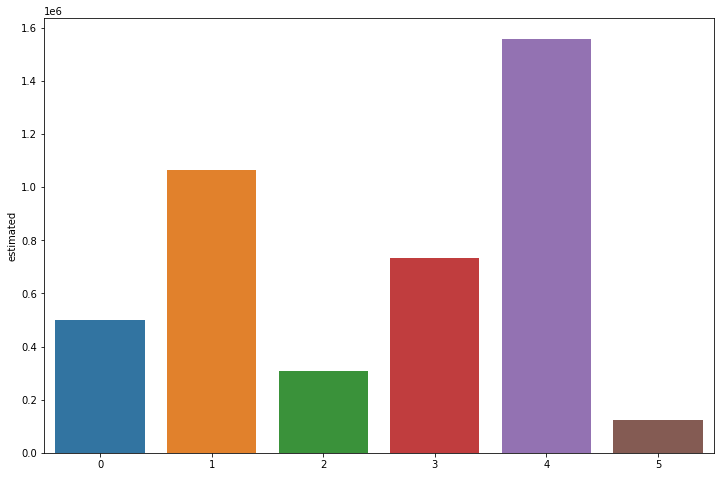

In [41]:
k = 6
X = train[['estimated']]
kmeans = KMeans(k, random_state=42)
kmeans.fit(X)
center = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
sns.barplot(x = center.index, y = center.estimated)